# Node generation

Since id_last_boss_employee and id_last_boss_boss have many categories that cannot be reduced, let's create node embeddings to catch their interactions between them and their employees

## Preparing environment

In [1]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec as n2v
import sys
sys.path.append('../high_performance_employee_resign_prediction')
from utils import paths

## Importing data

In [2]:
train_df = pd.read_csv(paths.data_interim_dir('train_clean.csv'))
test_df = pd.read_csv(paths.data_interim_dir('test_clean.csv'))

In [4]:
target = train_df['resign']
combined_df = pd.concat([train_df.drop('resign', axis=1), test_df]).reset_index(drop=True)

In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4172 entries, 0 to 4171
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id_employee_employee          4172 non-null   int64  
 1   id_last_boss_employee         4172 non-null   int64  
 2   seniority_employee            4172 non-null   int64  
 3   work_modality_employee        4172 non-null   object 
 4   office_distance_employee      4172 non-null   float64
 5   low_health_days_employee      4172 non-null   int64  
 6   gender_employee               4172 non-null   object 
 7   recruitment_channel_employee  4172 non-null   object 
 8   average_permanence_employee   4172 non-null   int64  
 9   salary_employee               4172 non-null   int64  
 10  performance_score_employee    4172 non-null   float64
 11  psi_score_employee            4172 non-null   int64  
 12  marital_estatus_employee      4172 non-null   object 
 13  joi

## Creating graph

In [8]:
G = nx.DiGraph()

In [9]:
# Adding nodes

for employee in combined_df['id_employee_employee']:
    G.add_node(employee)

In [10]:
# Adding Edges

for idx, row in combined_df.iterrows():
    G.add_edge(row['id_employee_employee'], row['id_last_boss_employee'])
    G.add_edge(row['id_last_boss_employee'], row['id_last_boss_boss'])

## Plotting graph

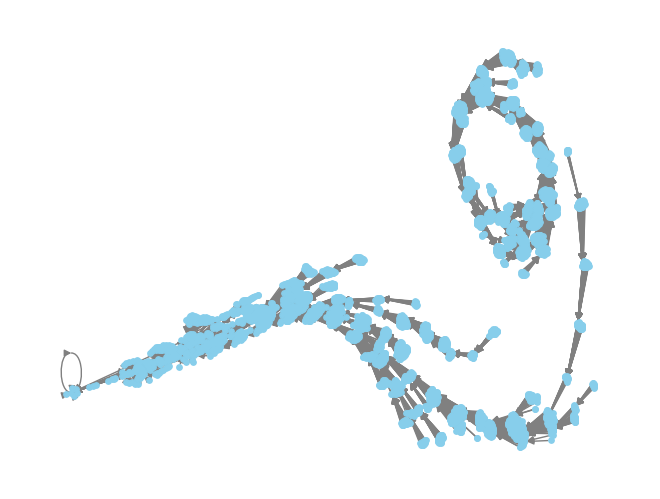

In [13]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=15, edge_color='gray')
plt.show()

## Generating Node Embeddings

In [14]:
# Precompute probabilities and generate walks

node2vec = n2v(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 4172/4172 [00:00<00:00, 10292.02it/s]


## Storing Node Embeddings

In [37]:
# Extract embeddings for each node
embeddings = {str(node): model.wv[str(node)] for node in G.nodes()}

# Convert embeddings to DataFrame for better visualization and manipulation
embeddings_df = pd.DataFrame.from_dict(embeddings, orient='index')

In [38]:
embeddings_df.index = embeddings_df.index.astype(int)  # Convert index to int if necessary
embeddings_df.reset_index(inplace=True)
embeddings_df.columns = ['id_employee'] + [f'embedding_{i}' for i in range(embeddings_df.shape[1] - 1)]

In [39]:
embeddings_df

,id_employee,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63
0,100247,0.002456,-0.005753,0.007775,0.000747,-0.003174,-0.000367,-0.004962,-0.007689,0.004519,...,0.000824,0.006621,0.006568,0.002709,-0.006552,0.001228,0.006418,-0.000617,0.006407,0.001035
1,103355,0.003666,-0.007632,0.000860,0.000593,-0.003614,-0.007141,-0.005126,0.004856,-0.003363,...,0.005688,-0.001202,0.004362,0.003413,-0.003665,0.004539,-0.002774,-0.007667,-0.001011,0.002869
2,100669,-0.006341,-0.003548,0.003287,0.000780,-0.004157,0.002590,0.003028,-0.002395,0.006164,...,-0.002128,-0.001630,0.004327,-0.000357,0.007228,-0.002115,0.002460,-0.001803,-0.005917,-0.004357
3,103760,0.002109,0.007152,-0.007091,-0.006100,0.003008,0.000109,0.000803,0.005040,0.002944,...,0.006047,0.001300,-0.005507,-0.000325,-0.000254,-0.002538,0.006050,-0.006192,-0.005526,-0.000557
4,100965,-0.004638,-0.007627,0.005105,0.007220,0.005573,-0.000827,-0.005053,-0.001190,0.006869,...,0.002624,0.006676,-0.004609,-0.002010,-0.004208,-0.002508,0.006853,0.005940,-0.000919,0.005338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4167,103755,0.003473,-0.000190,0.004861,0.002573,-0.003884,0.000838,0.006939,-0.000402,-0.006181,...,0.000022,0.006422,-0.006727,0.001916,0.007343,0.002884,-0.006171,-0.002648,0.000569,-0.005077
4168,103976,0.002013,-0.007080,0.005664,0.004533,-0.003819,0.001197,0.005741,0.000431,-0.006171,...,0.005097,-0.007437,-0.003145,-0.002010,-0.002142,0.003347,0.006807,0.005535,-0.003980,-0.002967
4169,104115,-0.007296,0.004529,0.005718,0.005096,0.006406,0.000354,0.007420,0.000084,0.000971,...,0.007748,0.000249,-0.007760,-0.001346,0.004943,0.003354,-0.003483,-0.001396,-0.000248,0.000024
4170,103920,0.007477,0.004857,-0.000697,-0.004182,-0.007258,0.003346,-0.004552,-0.002251,-0.007230,...,-0.004782,-0.000014,-0.000839,-0.003757,-0.003266,-0.000464,-0.003596,0.007380,-0.007055,-0.002378


## Merge node embeddings with original data

In [45]:
# Catching id_employee_employee embeddings

final_df = combined_df.merge(embeddings_df, left_on='id_employee_employee', right_on='id_employee', how='left')
final_df.drop('id_employee', axis=1, inplace=True)
final_df.columns = combined_df.columns.tolist() + [f'embedding_employee_{i}' for i in range(embeddings_df.shape[1] - 1)]
columns = final_df.columns.tolist()

# Catching id_boss_employee embeddings

final_df = final_df.merge(embeddings_df, left_on='id_last_boss_employee', right_on='id_employee', how='left')
final_df.drop('id_employee', axis=1, inplace=True)
final_df.columns = columns + [f'embedding_boss_{i}' for i in range(embeddings_df.shape[1] - 1)]
columns = final_df.columns.tolist()

# Catching id_boss_boss embeddings

final_df = final_df.merge(embeddings_df, left_on='id_last_boss_boss', right_on='id_employee', how='left')
final_df.drop('id_employee', axis=1, inplace=True)
final_df.columns = columns + [f'embedding_boss_boss_{i}' for i in range(embeddings_df.shape[1] - 1)]

In [46]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4172 entries, 0 to 4171
Columns: 232 entries, id_employee_employee to embedding_boss_boss_63
dtypes: float32(192), float64(5), int64(25), object(10)
memory usage: 4.3+ MB


## Split back into Train and Test DataFrames

In [54]:
train_new = final_df.loc[:len(train_df)-1,:].reset_index(drop=True)
test_new = final_df.loc[len(train_df):, :].reset_index(drop=True)

In [55]:
train_new = pd.concat([train_new, target], axis=1)

In [56]:
train_new

,id_employee_employee,id_last_boss_employee,seniority_employee,work_modality_employee,office_distance_employee,low_health_days_employee,gender_employee,recruitment_channel_employee,average_permanence_employee,salary_employee,...,embedding_boss_boss_55,embedding_boss_boss_56,embedding_boss_boss_57,embedding_boss_boss_58,embedding_boss_boss_59,embedding_boss_boss_60,embedding_boss_boss_61,embedding_boss_boss_62,embedding_boss_boss_63,resign
0,100247,102074,1,Híbrida,1.760,1,Mujer,Ferias & Networking,1,140011,...,2.446366,-0.572595,-0.494813,2.255403,1.609028,5.710031,-3.356178,-7.881370,-4.064664,0
1,103355,102115,1,Híbrida,0.760,2,Hombre,Ferias & Networking,2,182774,...,-2.060578,-1.533546,-2.596438,-3.254028,-1.945178,-0.940345,0.041342,-4.701263,1.085797,1
2,100669,102060,1,Híbrida,4.950,3,Mujer,Referidos,11,682106,...,-0.037716,0.194923,-0.216006,1.512420,-1.039239,2.266697,0.463412,0.805486,0.319538,0
3,103760,102062,1,Híbrida,13.030,2,Hombre,Linkedin,2,270232,...,-2.793977,-0.658350,-2.785280,0.215809,0.395154,1.203338,-1.181860,-0.421258,0.519029,1
4,100965,102062,1,Híbrida,13.045,2,Hombre,Linkedin,2,266804,...,-2.793977,-0.658350,-2.785280,0.215809,0.395154,1.203338,-1.181860,-0.421258,0.519029,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,103567,102171,1,Presencial,1.965,8,Mujer,Portal Web,3,281159,...,-3.011042,-7.761207,-2.340548,0.754459,-2.260126,2.947266,-2.760303,-2.141174,-4.094992,1
2148,104098,102172,1,Presencial,0.805,12,Mujer,Linkedin,13,460337,...,2.352668,-0.803404,-2.157203,-3.206896,0.264531,3.172269,2.300482,-2.717613,-5.120633,1
2149,103987,102155,1,Presencial,1.625,1,Hombre,Portal Web,11,633879,...,-0.399321,-1.860702,0.628043,0.943915,0.244801,0.225335,-1.971655,-0.424054,-0.095919,1
2150,103810,102141,1,Presencial,5.665,2,Hombre,Portal Web,6,793977,...,-3.304100,-1.796998,0.320826,-0.678250,0.694023,0.613303,1.719356,-2.936925,-0.662466,1


In [57]:
test_new

,id_employee_employee,id_last_boss_employee,seniority_employee,work_modality_employee,office_distance_employee,low_health_days_employee,gender_employee,recruitment_channel_employee,average_permanence_employee,salary_employee,...,embedding_boss_boss_54,embedding_boss_boss_55,embedding_boss_boss_56,embedding_boss_boss_57,embedding_boss_boss_58,embedding_boss_boss_59,embedding_boss_boss_60,embedding_boss_boss_61,embedding_boss_boss_62,embedding_boss_boss_63
0,100486,102115,1,Híbrida,0.795,2,Hombre,Ferias & Networking,2,181654,...,-0.341229,-2.060578,-1.533546,-2.596438,-3.254028,-1.945178,-0.940345,0.041342,-4.701263,1.085797
1,103752,102074,1,Híbrida,1.715,1,Mujer,Ferias & Networking,1,140986,...,-4.049683,2.446366,-0.572595,-0.494813,2.255403,1.609028,5.710031,-3.356178,-7.881370,-4.064664
2,103937,102150,1,Híbrida,2.375,1,Hombre,Portal Web,6,406690,...,4.386607,-2.766766,-0.577744,-1.055263,0.789598,3.714903,1.752868,-1.846730,-4.756254,-2.185360
3,101744,102172,1,Híbrida,2.185,3,Hombre,Linkedin,3,249107,...,0.262677,2.352668,-0.803404,-2.157203,-3.206896,0.264531,3.172269,2.300482,-2.717613,-5.120633
4,101037,102060,1,Híbrida,4.660,3,Hombre,Referidos,10,698318,...,2.873899,-0.037716,0.194923,-0.216006,1.512420,-1.039239,2.266697,0.463412,0.805486,0.319538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,103755,102161,1,Presencial,2.995,2,Mujer,Portal Web,16,700814,...,1.163380,0.192282,0.433766,1.714985,0.911830,0.835463,-0.078515,-2.172046,0.753051,0.631431
2016,103976,102171,1,Presencial,2.775,0,Mujer,Portal Web,5,677071,...,5.827570,-3.011042,-7.761207,-2.340548,0.754459,-2.260126,2.947266,-2.760303,-2.141174,-4.094992
2017,104115,102144,1,Presencial,3.990,1,Hombre,Portal Web,7,876285,...,1.958546,0.033315,-1.194680,-0.124152,1.918578,-2.038823,0.763704,1.733699,-1.215237,-0.582479
2018,103920,102152,1,Presencial,7.100,1,Mujer,Linkedin,8,719102,...,0.458564,-2.212007,2.220563,-0.548636,-0.814647,-2.957798,2.448870,-1.225921,0.338294,1.474732


## Saving new DataFrames

In [58]:
train_new.to_csv(paths.data_interim_dir('train_node.csv'), index=False, sep=',')
test_new.to_csv(paths.data_interim_dir('test_node.csv'), index=False, sep=',')